# Training and evaluating the models

In [1]:
!\cp *.py aws

In [2]:
!pip install -r requirements.txt --quiet

fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Setup

In [3]:
# plotting
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [5]:
import torch 
from dl_utils import *
from models import *
from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}!')

IMG_SIZE = 224

Running on cpu!


In [6]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

In [7]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

## Data

In [8]:
# # iterate through S3 objects and print contents
# counter = 0
# for obj in boto3.resource('s3').Bucket(bucket).objects.all():
#     if counter == 10:
#         break
#     print(obj.key)
#     counter += 1

In [9]:
input_data = 's3://sagemaker-eu-west-1-873555039102/images'

## Training

### V0

In [10]:
# specify an output path
prefix = 'model_v0'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train_color_cnn.py',
                    source_dir='aws', 
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'model-version': 'ColorCNN_v0',
                        'lab-version': 1
                    })

In [ ]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

### V1 small

In [9]:
# specify an output path
prefix = 'model_v1'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train_color_cnn.py',
                    source_dir='aws', 
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'model-version': 'ColorCNN_v1_small',
                        'lab-version': 1
                    })

In [ ]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

### V2

In [10]:
# specify an output path
prefix = 'model_v2'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train_color_cnn.py',
                    source_dir='aws', 
                    role=role,
                    framework_version='1.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 30,
                        'model-version': 'ColorCNN_v2',
                        'lab-version': 1
                    })

In [11]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

2020-04-14 18:13:56 Starting - Starting the training job...
2020-04-14 18:13:58 Starting - Launching requested ML instances.........
2020-04-14 18:15:28 Starting - Preparing the instances for training......
2020-04-14 18:16:30 Downloading - Downloading input data......
2020-04-14 18:17:41 Training - Downloading the training image........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-04-14 18:19:09,778 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-04-14 18:19:09,804 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-04-14 18:19:09,807 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-04-14 18:19:10,111 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2020-04-14 18:19:10,112 sagemaker-containers INFO     Generating setup.cfg
2020-04-14 18:1

## Evaluation

In [14]:
EVAL_TYPE = 'best' # or 'last_epoch'

### V0

In [14]:
# specify all the paths 
DEST_PATH = 'results/model_v0'
FROM_PATH = 'model_v0/pytorch-training-2020-04-14-14-34-04-829/output/model.tar.gz'
TO_PATH = os.path.join(DEST_PATH, 'model.tar.gz')
CHECKPOINT_PATH = os.path.join(DEST_PATH, f'model_{EVAL_TYPE}.pth.tar')

os.makedirs(DEST_PATH)

In [15]:
# download the data from S3
boto3.resource('s3').Bucket(bucket).download_file(FROM_PATH, TO_PATH)

# unpack the zip 
shutil.unpack_archive(TO_PATH, DEST_PATH)

# load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))

# instantiate the model and load the state dict for inference
model = ColorCNN_v0(lab_version=checkpoint['lab_version']).to(device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

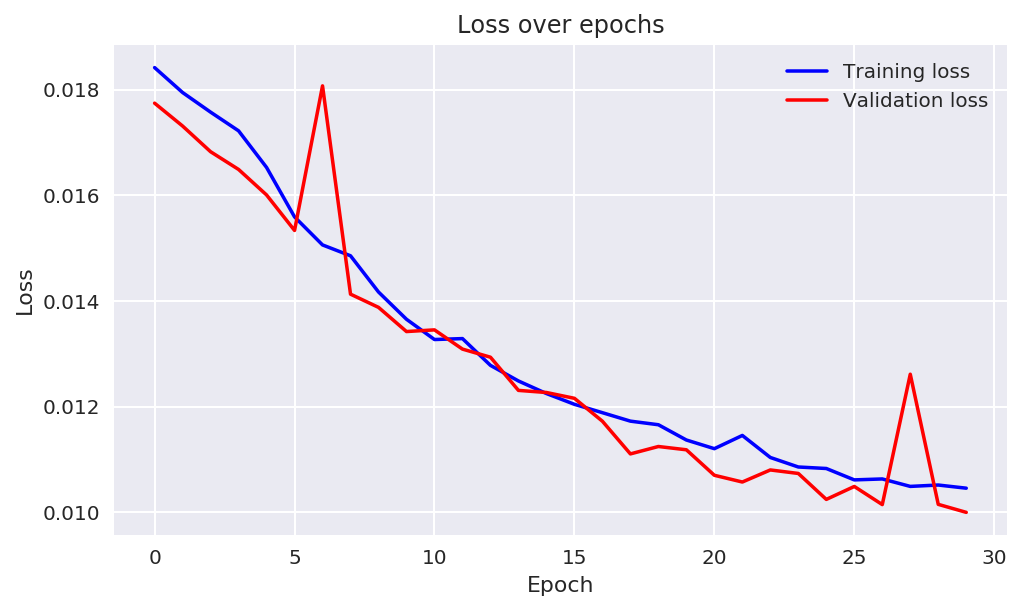

In [16]:
# plot the losses 
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']
plot_losses(train_losses, valid_losses)

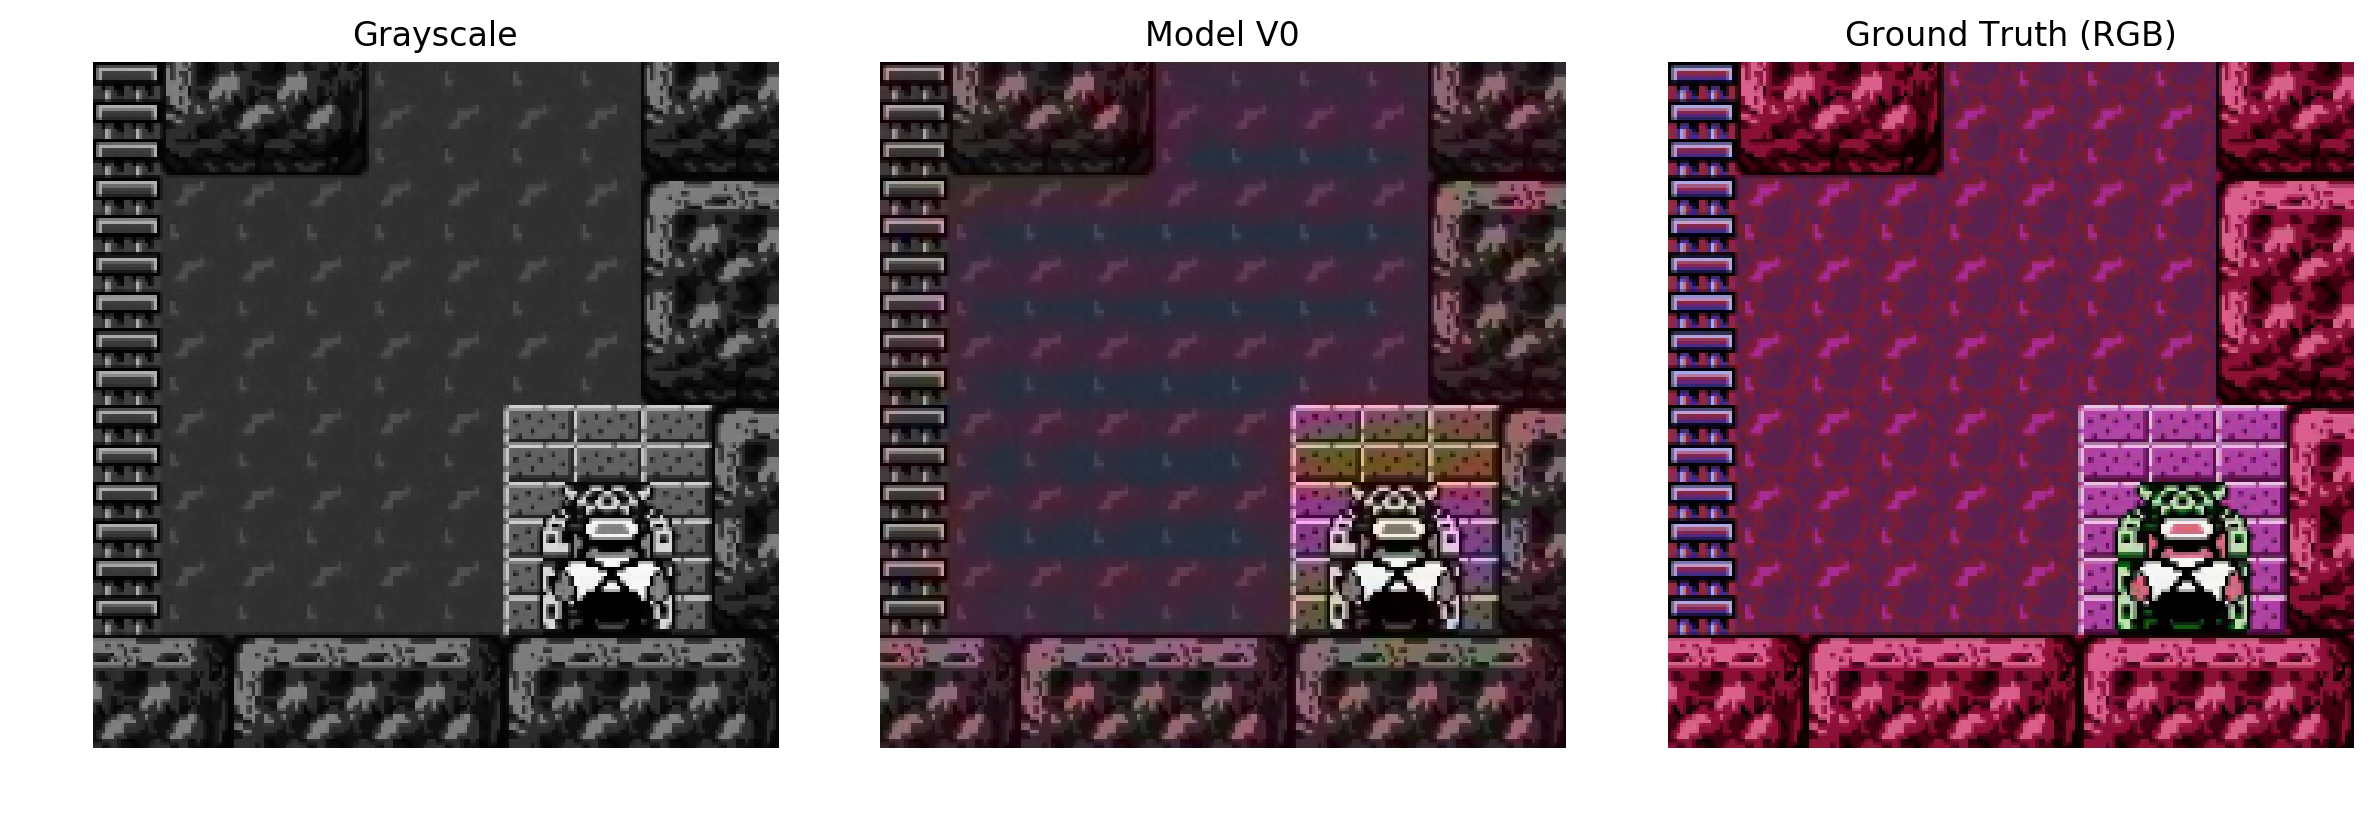

In [23]:
show_model_results(model, 
                   model_name='Model V0', 
                   lab_version=checkpoint['lab_version'], 
                   path=get_random_file('images/valid/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)

### V1 small

In [14]:
# specify all the paths 
DEST_PATH = 'results/model_v1'
FROM_PATH = 'model_v1/pytorch-training-2020-04-14-16-14-21-522/output/model.tar.gz'
TO_PATH = os.path.join(DEST_PATH, 'model.tar.gz')
CHECKPOINT_PATH = os.path.join(DEST_PATH, f'model_{EVAL_TYPE}.pth.tar')

os.makedirs(DEST_PATH, exist_ok=True)

In [15]:
# download the data from S3
boto3.resource('s3').Bucket(bucket).download_file(FROM_PATH, TO_PATH)

# unpack the zip 
shutil.unpack_archive(TO_PATH, DEST_PATH)

# load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))

# instantiate the model and load the state dict for inference
model = ColorCNN_v1_small(lab_version=checkpoint['lab_version']).to(device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

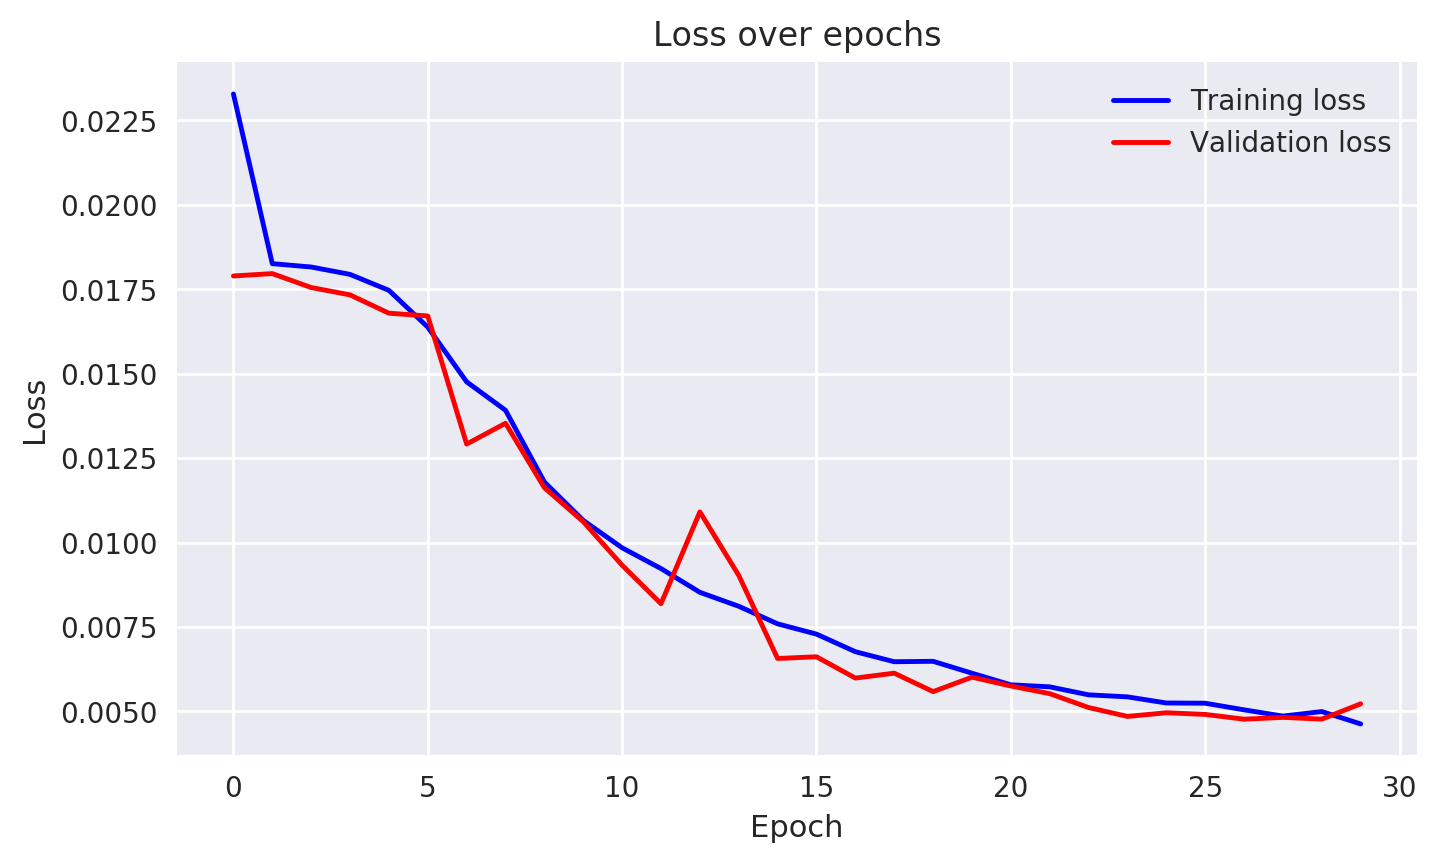

In [16]:
# plot the losses 
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']
plot_losses(train_losses, valid_losses)

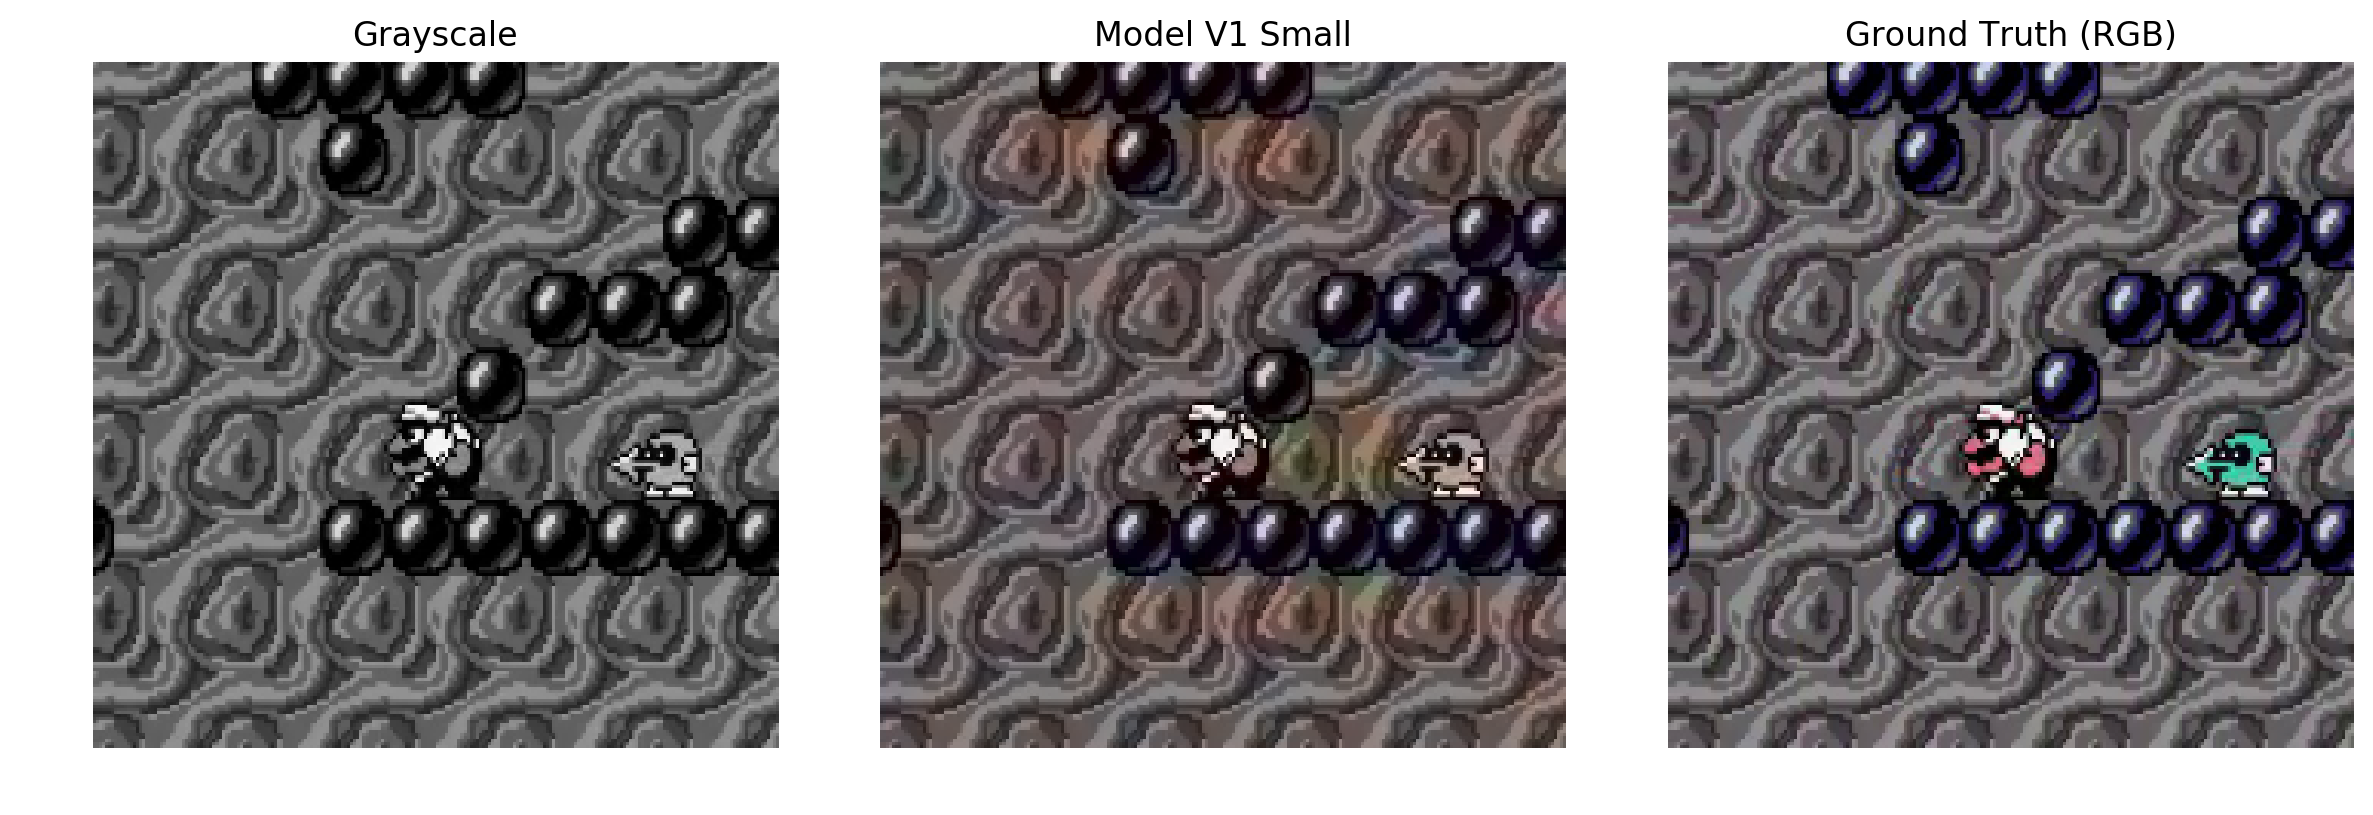

In [24]:
show_model_results(model, 
                   model_name='Model V1 Small', 
                   lab_version=checkpoint['lab_version'], 
                   path=get_random_file('images/valid/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)

### V2

In [15]:
# specify all the paths 
DEST_PATH = 'results/model_v2'
FROM_PATH = 'model_v2/pytorch-training-2020-04-14-18-13-55-751/output/model.tar.gz'
TO_PATH = os.path.join(DEST_PATH, 'model.tar.gz')
CHECKPOINT_PATH = os.path.join(DEST_PATH, f'model_{EVAL_TYPE}.pth.tar')

os.makedirs(DEST_PATH, exist_ok=True)

In [18]:
# download the data from S3
boto3.resource('s3').Bucket(bucket).download_file(FROM_PATH, TO_PATH)

# unpack the zip 
shutil.unpack_archive(TO_PATH, DEST_PATH)

# load the checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location=torch.device('cpu'))

# instantiate the model and load the state dict for inference
model = ColorCNN_v2(lab_version=checkpoint['lab_version']).to(device)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

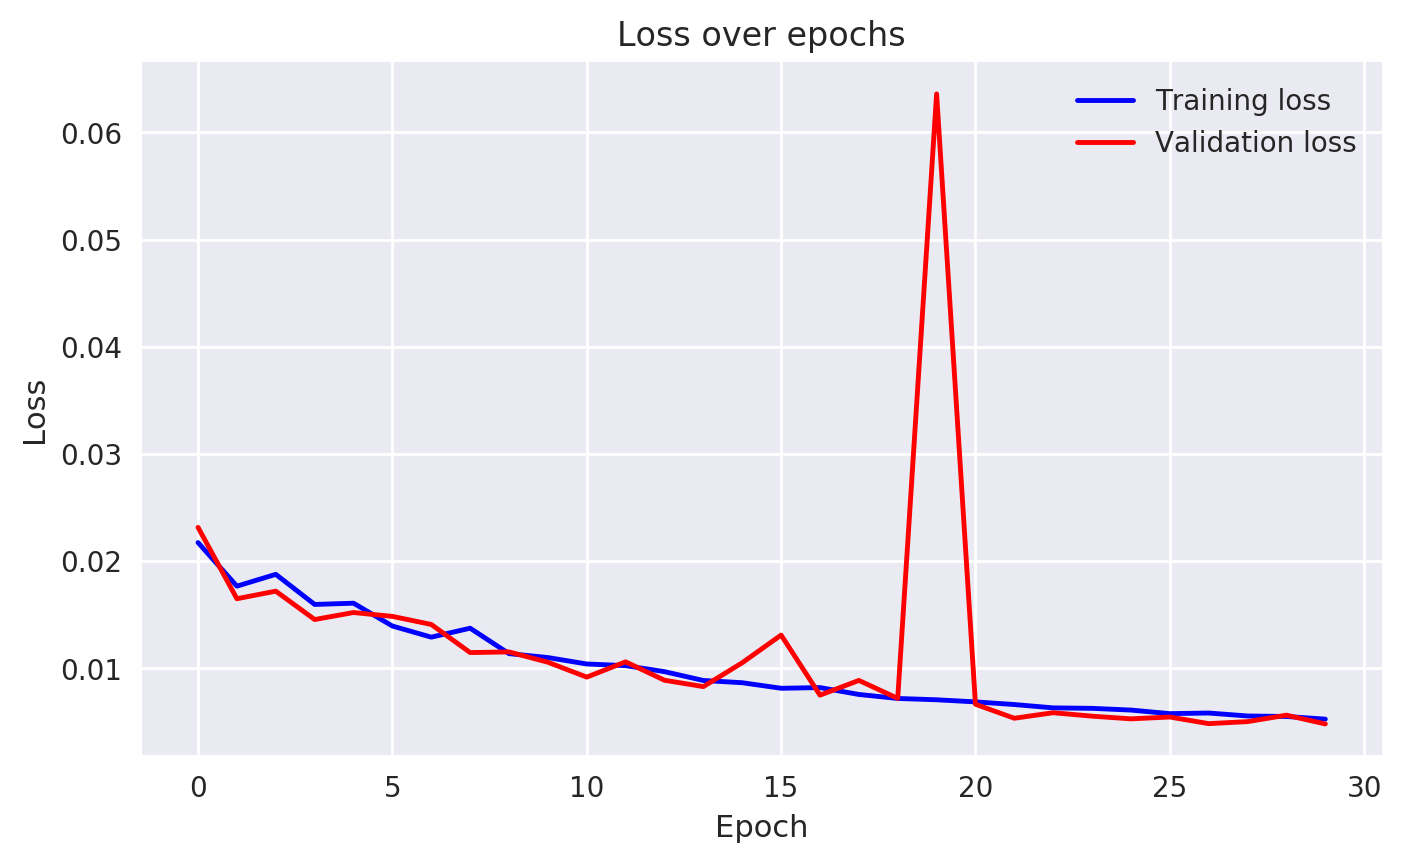

In [19]:
# plot the losses 
train_losses = checkpoint['train_losses']
valid_losses = checkpoint['valid_losses']
plot_losses(train_losses, valid_losses)

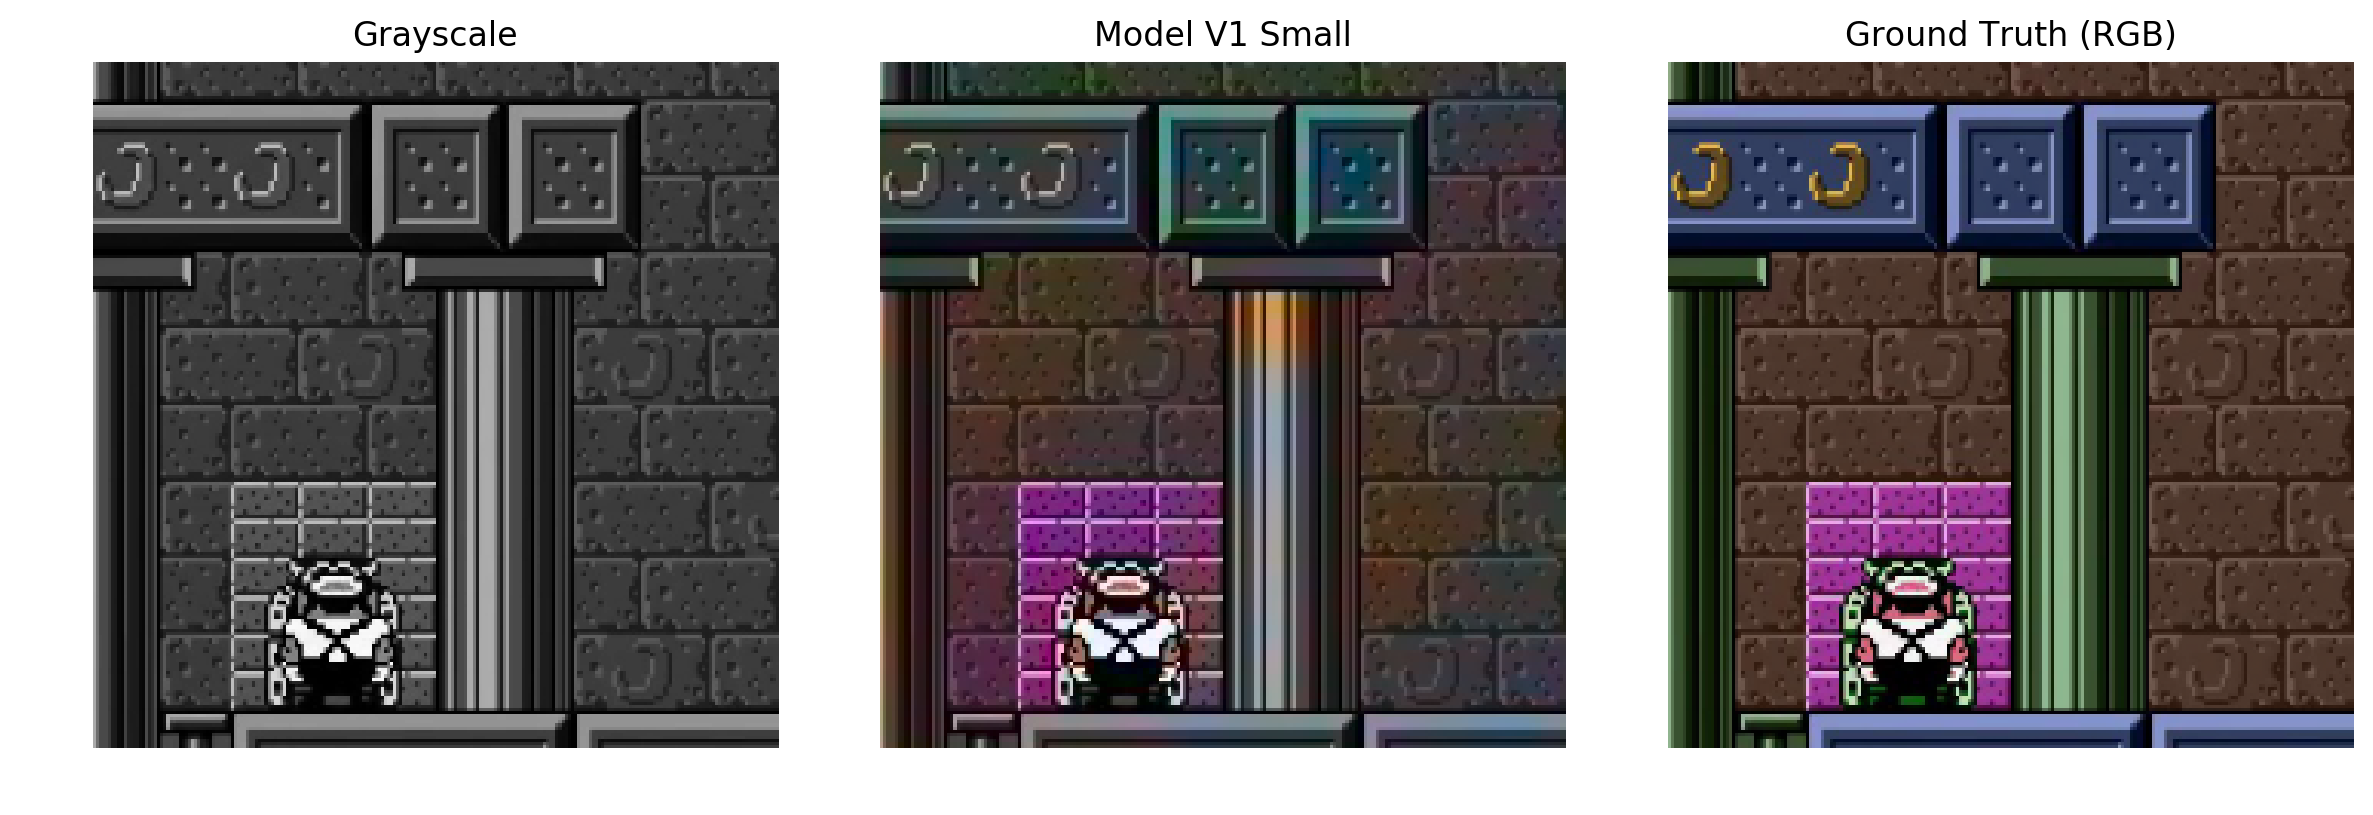

In [29]:
show_model_results(model, 
                   model_name='Model V1 Small', 
                   lab_version=checkpoint['lab_version'], 
                   path=get_random_file('images/valid/wario/', 'jpg'), 
                   img_size=IMG_SIZE, 
                   device=device)